In [1]:
# install tensorflow
import tensorflow as tf

implementation of a GAN (generative adversial network)

GAN architecture: consists of two combined networks
- a generator (G)
- a discriminator (D)

G & D learn in tandem!

for image classification:
- G learns to generate images from random noise, z
- G tries to "trick" D
- D classifies if the image is real or fake (generated)

loss: binary cross entropy

In [2]:
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, Adam

we'll do image classification using the MNIST dataset

In [6]:
# load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the data to (-1, 1), centered around 0
x_train, x_test = x_train/255.*2-1, x_test/255.*2-1

In [7]:
# flatten data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [ ]:
# dimensionality of the latent space
latent_dim = 100

now to build the models - this is done separately, and they are combined after

we'll do this by creating functions

In [ ]:
# generator (G)
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

note: tanh is used as we centered pixel values between 0 and 1

In [ ]:
# discriminator (D)
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [ ]:
# compile both models in preparation for training

# build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# build generator (not used directly during training)
generator = build_generator(latent_dim)

# creat an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# pass the noise into G to get an image
img = generator(z)

# make sure only the generator is train
discriminator.trainable = False

# the true output is fake, but we want to label them real!
fake_pred = discriminator(img)

# create combined model
combined_model = Model(z, fake_pred)

# compile the combined model
combined_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(0.0002, 0.5))

In [ ]:
# train the GAN
batch_size = 32
epochs = 30000

# every sample period, generate and save some data
sample_period = 200

# create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# lists to store the losses
d_losses = []
g_losses = []

# create folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

now that our model is created, we need to generate random samples from G and save them into a file

In [ ]:
# create random samples from G
def sample_images(epoch):
  # create images using G
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)

  # rescale images
  imgs = 0.5*imgs+0.5

  # save images
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off') # no lines in figures
      idx += 1
  fig.savefig('gan_images/%d.png' % epoch)
  plt.close()


now, let's train the model

In [ ]:
# main training loop
for epoch in range(epochs):
  # ************ discriminator ************

  # select random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5*(d_loss_real + d_loss_fake)
  d_acc = 0.5*(d_acc_real + d_acc_fake)

  # ************ generator ************

  # trained using the combined model (switch the labels, as we want to trick D)
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
epoch: 25101/30000, d_loss: 0.61, d_acc: 0.70, g_loss: 0.98
1/1 [==============================] - 0s 25ms/step
epoch: 25201/30000, d_loss: 0.59, d_acc: 0.69, g_loss: 1.03
1/1 [==============================] - 0s 25ms/step
epoch: 25301/30000, d_loss: 0.61, d_acc: 0.67, g_loss: 1.00
1/1 [==============================] - 0s 24ms/step
epoch: 25401/30000, d_loss: 0.65, d_acc: 0.58, g_loss: 1.12
1/1 [==============================] - 0s 38ms/step
epoch: 25501/30000, d_loss: 0.57, d_acc: 0.73, g_loss: 1.06
1/1 [==============================] - 0s 25ms/step
epoch: 25601/30000, d_loss: 0.63, d_acc: 0.55, g_loss: 1.04
1/1 [==============================] - 0s 25ms/step
epoch: 25701/30000, d_loss: 0.58, d_acc: 0.72, g_loss: 1.13
1/1 [==============================] - 0s 24ms/step
epoch: 25801/30000, d_loss: 0.61, d_acc: 0.69, g_loss: 0.91
1/1 [==============================] - 0s 28ms/step
e

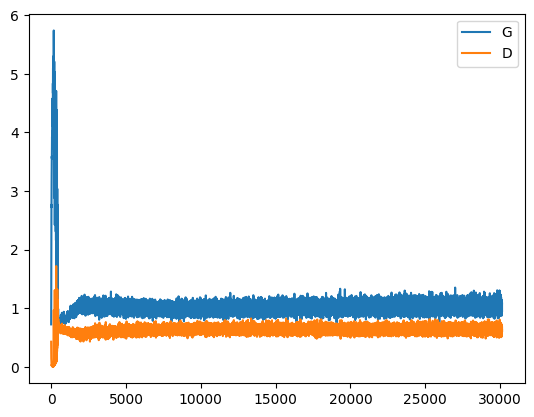

In [ ]:
# loss
plt.plot(g_losses, label='G')
plt.plot(d_losses, label='D')
plt.legend()
plt.show()

In [ ]:
!ls gan_images/

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

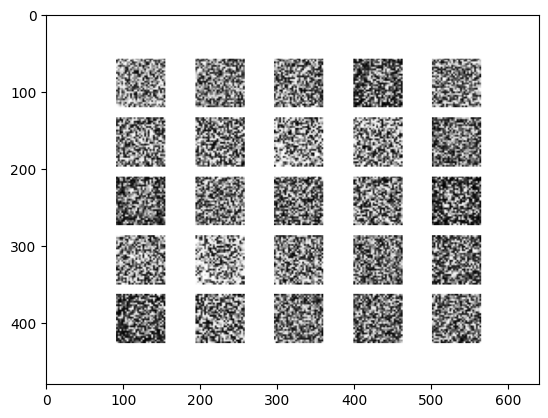

In [ ]:
# lets look at some images - first, lets look at beginning of training
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)
plt.show()

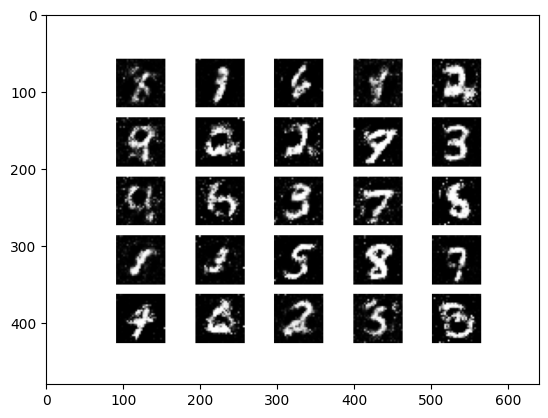

In [ ]:
# next, epoch 5000
a = imread('gan_images/5000.png')
plt.imshow(a)
plt.show()

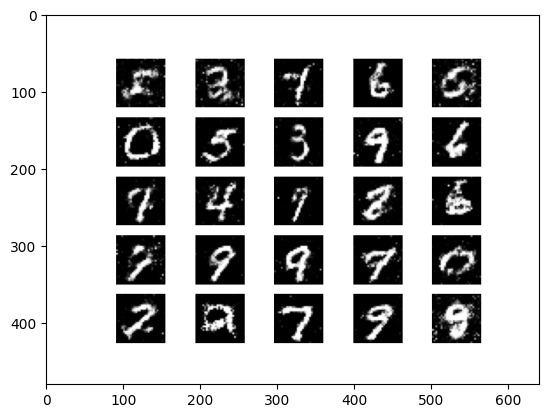

In [ ]:
# next, epoch 10000
a = imread('gan_images/10000.png')
plt.imshow(a)
plt.show()

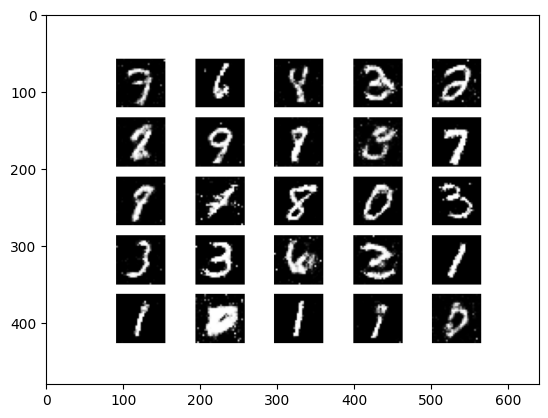

In [ ]:
# next, epoch 29800 (last batch saved)
a = imread('gan_images/29800.png')
plt.imshow(a)
plt.show()

so by the end, the generator looks like it can replicate MNIST!